In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, TFAutoModel, AutoTokenizer, BertTokenizer
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

2025-05-27 23:25:25.024647: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = tf.data.Dataset.load(
    "dataset",
    element_spec=({
        'title': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'content': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'titlemask': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'contentmask': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8)
    }, tf.TensorSpec(shape=(None, 2), dtype=tf.float64))
)

dataVal = tf.data.Dataset.load(
    "dataVal",
    element_spec=({
        'title': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'content': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'titlemask': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'contentmask': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8)
    }, tf.TensorSpec(shape=(None, 2), dtype=tf.float64))
)

2025-05-27 23:25:30.377482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-27 23:25:30.410740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-27 23:25:30.410787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-27 23:25:30.413821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-27 23:25:30.413862: I external/local_xla/xla/stream_executor

In [ ]:
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super(BertEmbeddingLayer, self).__init__(**kwargs)
        self.model_name = model_name
        self.embedding_size = None
        self.bert = None

    def build(self, input_shape):
        self.bert = TFAutoModel.from_pretrained(self.model_name)
        self.embedding_size = self.bert.config.hidden_size
        super(BertEmbeddingLayer, self).build(input_shape)

    def call(self, inputs):
        ids, att = inputs
        outputs = self.bert(input_ids=ids, attention_mask=att)
        return outputs.pooler_output

    def get_config(self):
        config = super(BertEmbeddingLayer, self).get_config()
        config.update({"model_name": self.model_name})
        return config

# Model stuff

## text only

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._0/output/dense/kernel:0', 'bert/embeddings/LayerNorm/beta:0', 'bert/encoder/layer_._9/intermediate/dense/bias:0', 'bert/encoder/layer_._10/output/LayerNorm/beta:0', 'bert/encoder/layer_._8/output/dense/bias:0', 'bert/encoder/layer_._3/attention/output/dense/bias:0', 'bert/encoder/layer_._8/attention/self/value/bias:0', 'bert/encoder/layer_._10/attention/output/dense/kernel:0', 'bert/encoder/layer_._1/attention/self/value/bias:0', 'bert/encoder/layer_._5/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._8/attention/self/query/bias:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert/encoder/layer_._6/attention/self/key/kernel:0', 'bert/encoder/layer_._4/intermediate/dense/kernel:0', 'bert/encoder/layer_._8/intermediate/dense/bias:0', 'bert/pooler/dense/b

Epoch 1/50


I0000 00:00:1748325126.941965   34705 service.cc:145] XLA service 0x7f62fc006a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748325126.942006   34705 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-05-27 12:52:07.523825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1748325127.574895   34705 assert_op.cc:38] Ignoring Assert operator functional_1/indobert1_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748325127.666455   34705 assert_op.cc:38] Ignoring Assert operator functional_1/indobert2_1/tf_bert_model_1/bert/embeddings/assert_less/Assert/Assert
2025-05-27 12:52:09.906115: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1748325133.052545   34895 asm_compiler.cc:369] ptxas warning :

349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - binary_accuracy: 0.5526 - loss: 0.7675 - precision: 0.5526 - recall: 0.5526

W0000 00:00:1748325169.626223   34707 assert_op.cc:38] Ignoring Assert operator functional_1/indobert1_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748325169.631625   34707 assert_op.cc:38] Ignoring Assert operator functional_1/indobert2_1/tf_bert_model_1/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748325174.204423   35011 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_25', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1748325174.509340   35015 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_25', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1748325174.628157   35007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_25', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1748325174.705293   35003 asm_compiler.cc:369] ptxas warning : Registers are spilled to 

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - binary_accuracy: 0.5526 - loss: 0.7675 - precision: 0.5526 - recall: 0.5526

W0000 00:00:1748325186.018224   34702 assert_op.cc:38] Ignoring Assert operator functional_1/indobert1_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748325186.089467   34702 assert_op.cc:38] Ignoring Assert operator functional_1/indobert2_1/tf_bert_model_1/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748325187.324166   35248 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11566', 8 bytes spill stores, 8 bytes spill loads

W0000 00:00:1748325196.390906   34708 assert_op.cc:38] Ignoring Assert operator functional_1/indobert1_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748325196.395622   34708 assert_op.cc:38] Ignoring Assert operator functional_1/indobert2_1/tf_bert_model_1/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748325197.579955   35340 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 20 bytes spil

350/350 ━━━━━━━━━━━━━━━━━━━━ 87s 178ms/step - binary_accuracy: 0.5527 - loss: 0.7674 - precision: 0.5527 - recall: 0.5527 - val_binary_accuracy: 0.6314 - val_loss: 0.6739 - val_precision: 0.6314 - val_recall: 0.6314 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - binary_accuracy: 0.6125 - loss: 0.6951 - precision: 0.6125 - recall: 0.6125 - val_binary_accuracy: 0.6707 - val_loss: 0.6253 - val_precision: 0.6707 - val_recall: 0.6707 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - binary_accuracy: 0.6534 - loss: 0.6533 - precision: 0.6534 - recall: 0.6534 - val_binary_accuracy: 0.6879 - val_loss: 0.6000 - val_precision: 0.6879 - val_recall: 0.6879 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - binary_accuracy: 0.6773 - loss: 0.6230 - precision: 0.6773 - recall: 0.6773 - val_binary_accuracy: 0.6926 - val_loss: 0.5851 - val_precision: 0.6926 - val_recall: 0.6926 - learning_rate: 5.

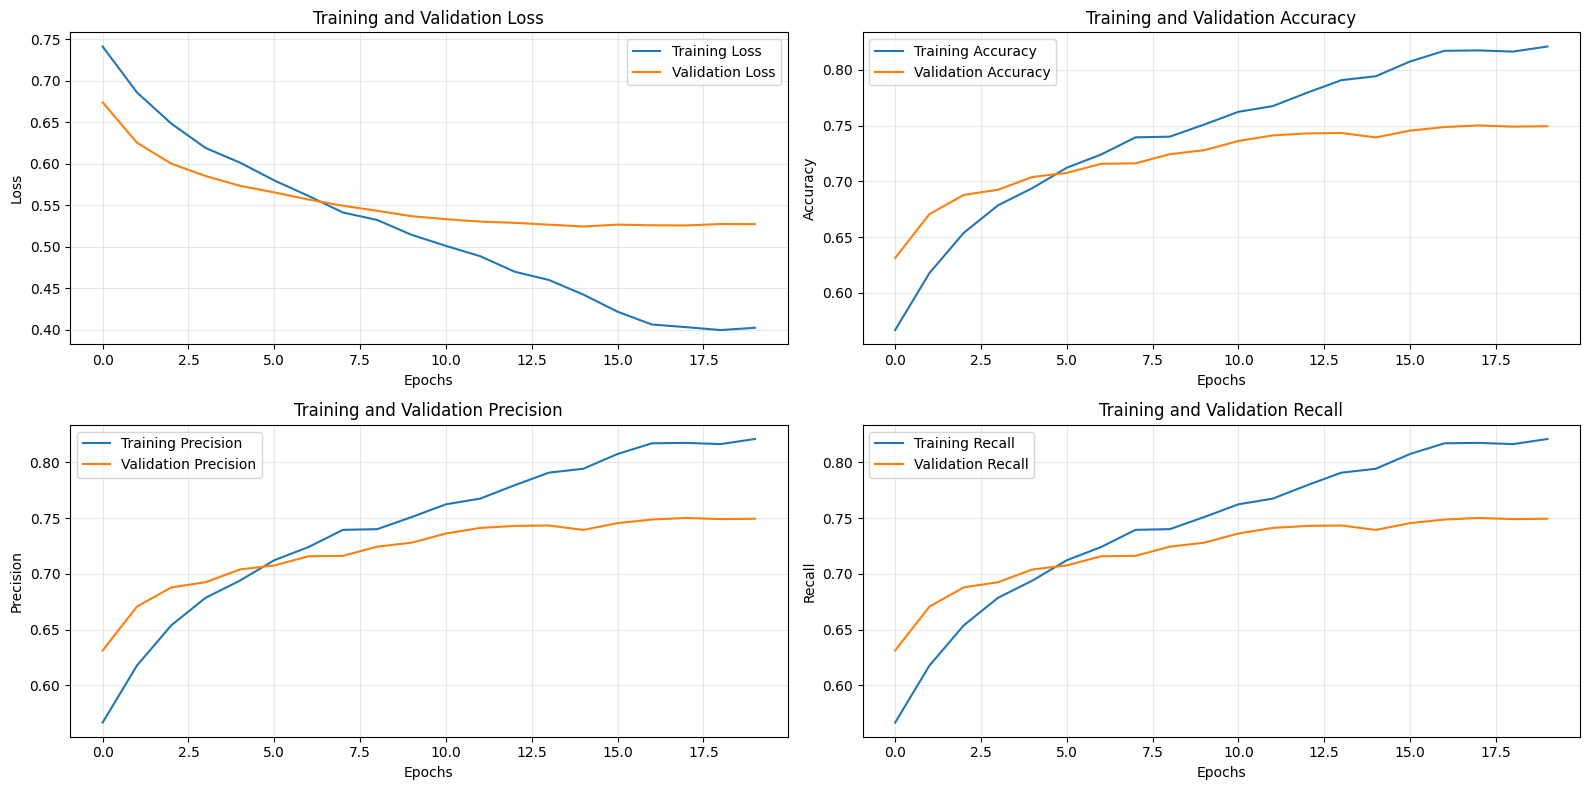


FINAL METRICS SUMMARY
Loss           : Train = 0.4023, Val = 0.5272
Binary_accuracy: Train = 0.8209, Val = 0.7495
Precision      : Train = 0.8209, Val = 0.7495
Recall         : Train = 0.8209, Val = 0.7495


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")
    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    title = indobert1([ids1, att1])
    content = indobert2([ids2, att2])

    fin = tf.keras.layers.concatenate([title, content])
    
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

textOnly = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/text_only_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=textOnly.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## title & image

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._2/output/dense/bias:0', 'bert/encoder/layer_._11/attention/self/key/bias:0', 'bert/encoder/layer_._10/intermediate/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/bias:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/layer_._8/output/LayerNorm/beta:0', 'bert/encoder/layer_._6/attention/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/self/key/bias:0', 'bert/encoder/layer_._10/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/output/dense/bias:0', 'bert/encoder/layer_._7/attention/self/value/bias:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50


2025-05-27 13:56:48.743663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-05-27 13:56:53.171586: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


350/350 ━━━━━━━━━━━━━━━━━━━━ 197s 443ms/step - binary_accuracy: 0.4861 - loss: 0.8417 - precision: 0.4861 - recall: 0.4861 - val_binary_accuracy: 0.6181 - val_loss: 0.6677 - val_precision: 0.6181 - val_recall: 0.6181 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 153s 438ms/step - binary_accuracy: 0.5771 - loss: 0.7160 - precision: 0.5771 - recall: 0.5771 - val_binary_accuracy: 0.6593 - val_loss: 0.6348 - val_precision: 0.6593 - val_recall: 0.6593 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 150s 430ms/step - binary_accuracy: 0.6155 - loss: 0.6917 - precision: 0.6155 - recall: 0.6155 - val_binary_accuracy: 0.6657 - val_loss: 0.6201 - val_precision: 0.6657 - val_recall: 0.6657 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 151s 431ms/step - binary_accuracy: 0.6395 - loss: 0.6649 - precision: 0.6395 - recall: 0.6395 - val_binary_accuracy: 0.6739 - val_loss: 0.6115 - val_precision: 0.6739 - val_recall: 0.6739 - learning_rate

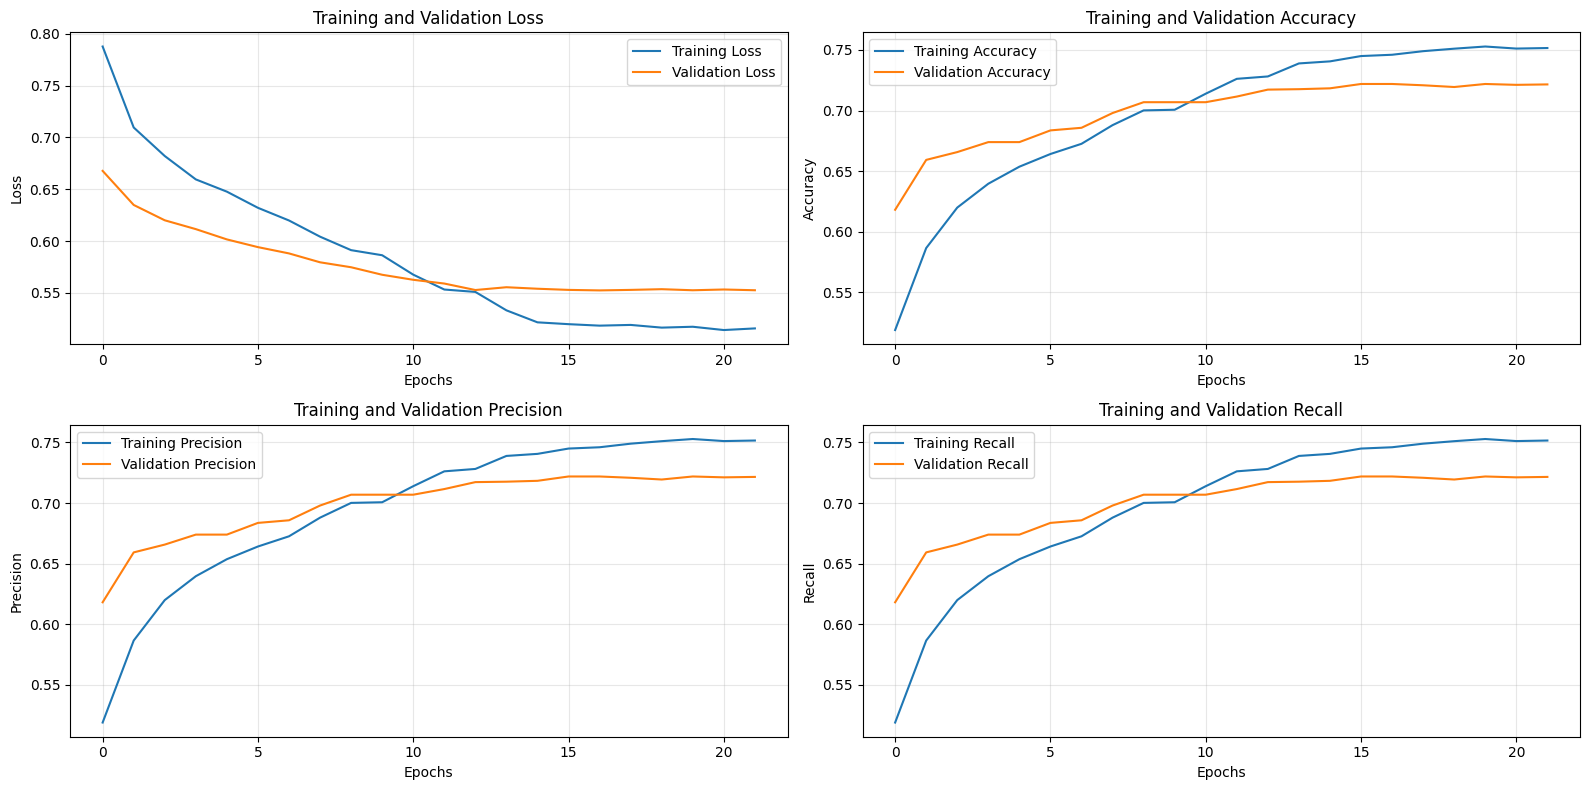


FINAL METRICS SUMMARY
Loss           : Train = 0.5158, Val = 0.5526
Binary_accuracy: Train = 0.7516, Val = 0.7215
Precision      : Train = 0.7516, Val = 0.7215
Recall         : Train = 0.7516, Val = 0.7215


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")

    title = indobert1([ids1, att1])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

titleImage = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/title_image_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=titleImage.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## content & image

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._2/output/dense/bias:0', 'bert/encoder/layer_._11/attention/self/key/bias:0', 'bert/encoder/layer_._10/intermediate/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/bias:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/layer_._8/output/LayerNorm/beta:0', 'bert/encoder/layer_._6/attention/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/self/key/bias:0', 'bert/encoder/layer_._10/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/output/dense/bias:0', 'bert/encoder/layer_._7/attention/self/value/bias:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 150s 429ms/step - binary_accuracy: 0.7447 - loss: 0.5222 - precision: 0.7447 - recall: 0.7447 - val_binary_accuracy: 0.7205 - val_loss: 0.5543 - val_precision: 0.7205 - val_recall: 0.7205 - learning_rate: 1.0000e-08
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 150s 429ms/step - binary_accuracy: 0.7425 - loss: 0.5275 - precision: 0.7425 - recall: 0.7425 - val_binary_accuracy: 0.7190 - val_loss: 0.5539 - val_precision: 0.7190 - val_recall: 0.7190 - learning_rate: 1.0000e-08
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 153s 438ms/step - binary_accuracy: 0.7513 - loss: 0.5193 - precision: 0.7513 - recall: 0.7513 - val_binary_accuracy: 0.7201 - val_loss: 0.5527 - val_precision: 0.7201 - val_recall: 0.7201 - learning_rate: 1.0000e-08
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 150s 430ms/step - binary_accuracy: 0.7460 - loss: 0.5231 - precision: 0.7460 - recall: 0.7460 - val_binary_accuracy: 0.7208 - val_loss: 0.5525 - val_precision: 0.7208 - val_recall: 0.7208 - le

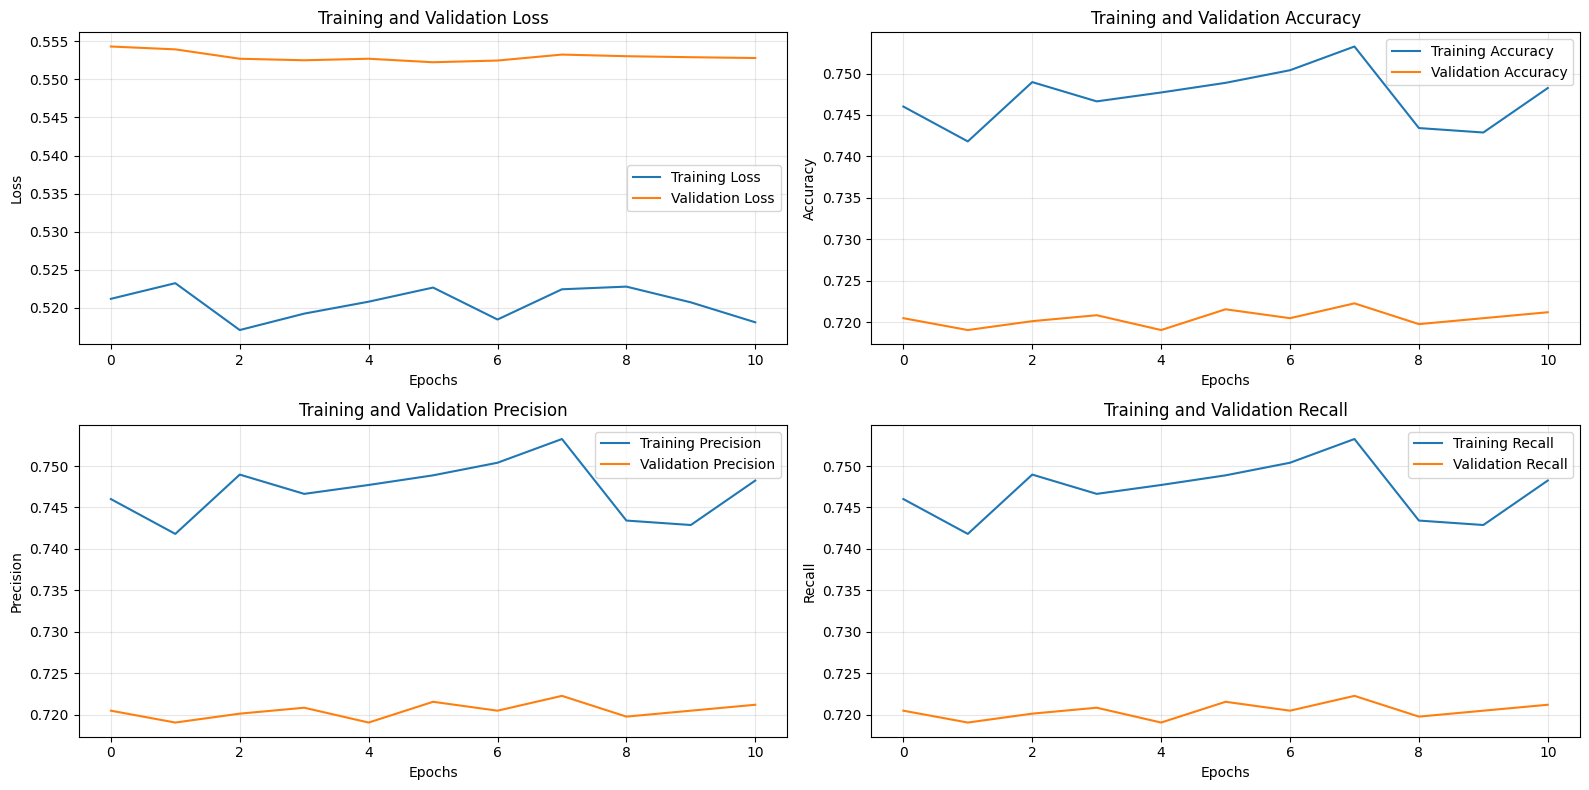


FINAL METRICS SUMMARY
Loss           : Train = 0.5181, Val = 0.5528
Binary_accuracy: Train = 0.7483, Val = 0.7212
Precision      : Train = 0.7483, Val = 0.7212
Recall         : Train = 0.7483, Val = 0.7212


In [ ]:
def makemodel(output_bias=None):
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    content = indobert2([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

contentImage = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/content_image_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=titleImage.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## title only

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._2/output/dense/bias:0', 'bert/encoder/layer_._11/attention/self/key/bias:0', 'bert/encoder/layer_._10/intermediate/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/bias:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/layer_._8/output/LayerNorm/beta:0', 'bert/encoder/layer_._6/attention/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/self/key/bias:0', 'bert/encoder/layer_._10/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/output/dense/bias:0', 'bert/encoder/layer_._7/attention/self/value/bias:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50


I0000 00:00:1748334033.026205   45754 service.cc:145] XLA service 0x7f2600024100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748334033.026351   45754 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
W0000 00:00:1748334033.293516   45754 assert_op.cc:38] Ignoring Assert operator functional_2_1/indobert1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert
2025-05-27 15:20:33.377775: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748334037.429932   54634 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1748334037.437949   54637 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 12 bytes spil

  1/350 ━━━━━━━━━━━━━━━━━━━━ 1:36:50 17s/step - binary_accuracy: 0.4375 - loss: 1.3790 - precision_2: 0.4375 - recall_2: 0.4375

I0000 00:00:1748334041.468644   45754 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


347/350 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.4768 - loss: 1.1097 - precision_2: 0.4768 - recall_2: 0.4767

W0000 00:00:1748334051.439254   45763 assert_op.cc:38] Ignoring Assert operator functional_2_1/indobert1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748334054.560203   54712 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1748334054.692262   54715 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1748334054.807962   54726 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1748334054.836738   54730 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1748334055.149000   54711 asm_compiler.cc:369] ptxas warn

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.4771 - loss: 1.1085 - precision_2: 0.4771 - recall_2: 0.4769

W0000 00:00:1748334060.561444   45753 assert_op.cc:38] Ignoring Assert operator functional_2_1/indobert1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748334061.671739   54918 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5839', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1748334061.791873   54914 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5839', 8 bytes spill stores, 8 bytes spill loads

W0000 00:00:1748334064.872134   45753 assert_op.cc:38] Ignoring Assert operator functional_2_1/indobert1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748334065.462781   55023 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1748334065.644378   55020 asm_compiler.cc:369] ptxas warning : Registers are spil

350/350 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - binary_accuracy: 0.4772 - loss: 1.1081 - precision_2: 0.4772 - recall_2: 0.4770 - val_binary_accuracy: 0.5535 - val_loss: 0.6824 - val_precision_2: 0.5536 - val_recall_2: 0.5530 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - binary_accuracy: 0.5646 - loss: 0.8151 - precision_2: 0.5647 - recall_2: 0.5643 - val_binary_accuracy: 0.6401 - val_loss: 0.6364 - val_precision_2: 0.6403 - val_recall_2: 0.6396 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - binary_accuracy: 0.5716 - loss: 0.7841 - precision_2: 0.5716 - recall_2: 0.5715 - val_binary_accuracy: 0.6478 - val_loss: 0.6269 - val_precision_2: 0.6479 - val_recall_2: 0.6475 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - binary_accuracy: 0.5942 - loss: 0.7372 - precision_2: 0.5943 - recall_2: 0.5941 - val_binary_accuracy: 0.6580 - val_loss: 0.6207 - val_precision_2: 0.6582 - val_recall_2: 

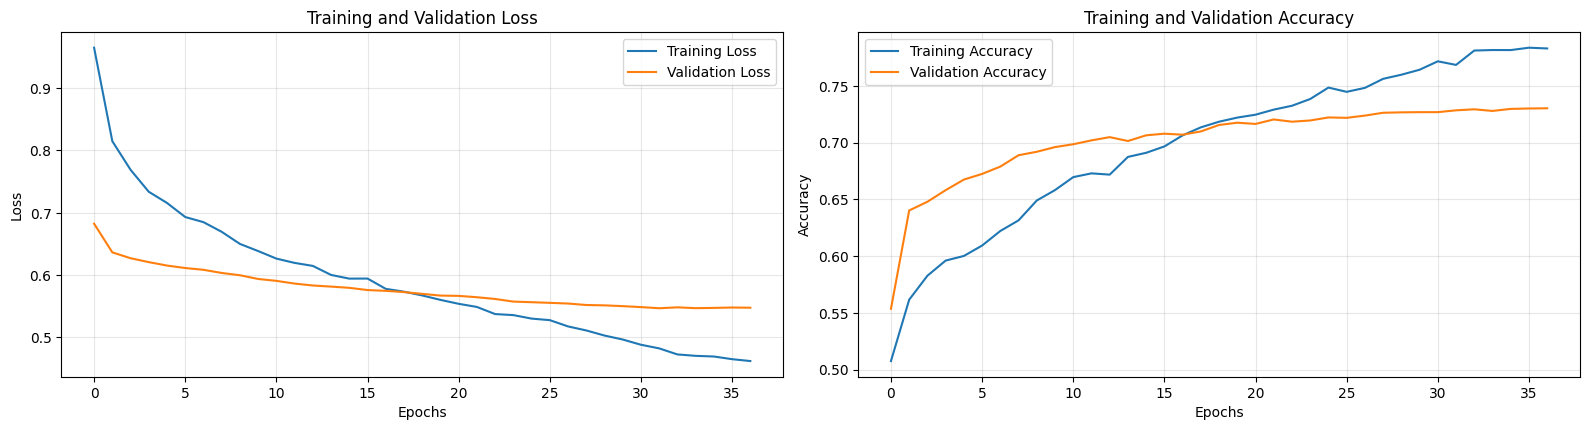


FINAL METRICS SUMMARY
Loss           : Train = 0.4617, Val = 0.5474
Binary_accuracy: Train = 0.7828, Val = 0.7301


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")

    title = indobert1([ids1, att1])
    fin = tf.keras.layers.BatchNormalization()(title)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids1, att1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

titleOnly = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/title_only_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=titleOnly.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## content only

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._2/output/dense/bias:0', 'bert/encoder/layer_._11/attention/self/key/bias:0', 'bert/encoder/layer_._10/intermediate/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/bias:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/layer_._8/output/LayerNorm/beta:0', 'bert/encoder/layer_._6/attention/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/self/key/bias:0', 'bert/encoder/layer_._10/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/output/dense/bias:0', 'bert/encoder/layer_._7/attention/self/value/bias:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50


W0000 00:00:1748334406.925501   45748 assert_op.cc:38] Ignoring Assert operator functional_3_1/indobert2_1/tf_bert_model_3/bert/embeddings/assert_less/Assert/Assert


349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - binary_accuracy: 0.5155 - loss: 0.8801 - precision_3: 0.5155 - recall_3: 0.5152

W0000 00:00:1748334439.491780   45748 assert_op.cc:38] Ignoring Assert operator functional_3_1/indobert2_1/tf_bert_model_3/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748334443.495697   64329 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1748334443.516890   64334 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1748334443.640099   64324 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1748334443.688164   64327 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1748334444.089879   64333 asm_compiler.cc:369] ptxas warn

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - binary_accuracy: 0.5156 - loss: 0.8800 - precision_3: 0.5156 - recall_3: 0.5153

W0000 00:00:1748334450.145397   45748 assert_op.cc:38] Ignoring Assert operator functional_3_1/indobert2_1/tf_bert_model_3/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748334457.146536   45752 assert_op.cc:38] Ignoring Assert operator functional_3_1/indobert2_1/tf_bert_model_3/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748334457.746252   64560 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1748334457.900306   64569 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1748334457.996646   64564 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1748334458.045906   64561 asm_compiler.cc:369] ptxas warning : Registers are spilled 

350/350 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step - binary_accuracy: 0.5156 - loss: 0.8799 - precision_3: 0.5156 - recall_3: 0.5153 - val_binary_accuracy: 0.6135 - val_loss: 0.6711 - val_precision_3: 0.6137 - val_recall_3: 0.6124 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - binary_accuracy: 0.5729 - loss: 0.7685 - precision_3: 0.5730 - recall_3: 0.5725 - val_binary_accuracy: 0.6392 - val_loss: 0.6374 - val_precision_3: 0.6393 - val_recall_3: 0.6389 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - binary_accuracy: 0.5905 - loss: 0.7348 - precision_3: 0.5906 - recall_3: 0.5902 - val_binary_accuracy: 0.6485 - val_loss: 0.6257 - val_precision_3: 0.6485 - val_recall_3: 0.6485 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - binary_accuracy: 0.5725 - loss: 0.7333 - precision_3: 0.5725 - recall_3: 0.5724 - val_binary_accuracy: 0.6550 - val_loss: 0.6211 - val_precision_3: 0.6554 - val_recall_

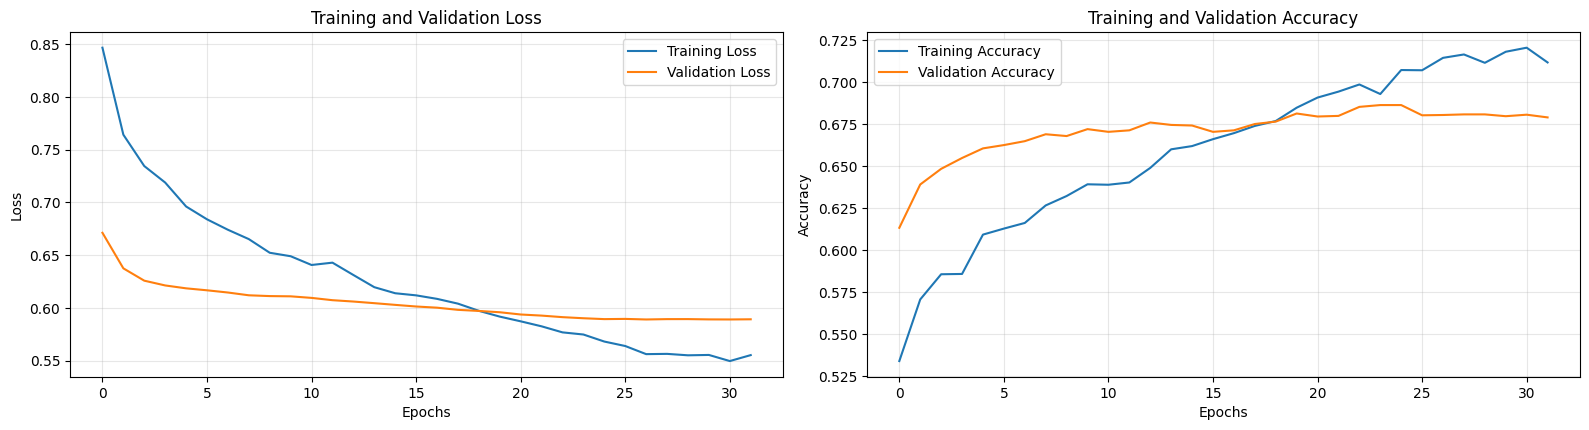


FINAL METRICS SUMMARY
Loss           : Train = 0.5551, Val = 0.5891
Binary_accuracy: Train = 0.7118, Val = 0.6791


In [ ]:
def makemodel(output_bias=None):
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    content = indobert2([ids2, att2])

    fin = tf.keras.layers.BatchNormalization()(content)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids2, att2], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

contentOnly = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/content_only_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=contentOnly.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## img only

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 181s 405ms/step - binary_accuracy: 0.4905 - loss: 0.8712 - precision_4: 0.4905 - recall_4: 0.4899 - val_binary_accuracy: 0.5993 - val_loss: 0.6714 - val_precision_4: 0.5994 - val_recall_4: 0.5988 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 139s 396ms/step - binary_accuracy: 0.5427 - loss: 0.7772 - precision_4: 0.5427 - recall_4: 0.5420 - val_binary_accuracy: 0.6147 - val_loss: 0.6628 - val_precision_4: 0.6148 - val_recall_4: 0.6142 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 138s 395ms/step - binary_accuracy: 0.5531 - loss: 0.7403 - precision_4: 0.5531 - recall_4: 0.5525 - val_binary_accuracy: 0.6242 - val_loss: 0.6571 - val_precision_4: 0.6245 - val_recall_4: 0.6231 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 139s 396ms/step - binary_accuracy: 0.5577 - loss: 0.7294 - precision_4: 0.5577 - recall_4: 0.5573 - val_binary_accuracy: 0.6192 - val_loss: 0.6539 - val_precision_4: 0.

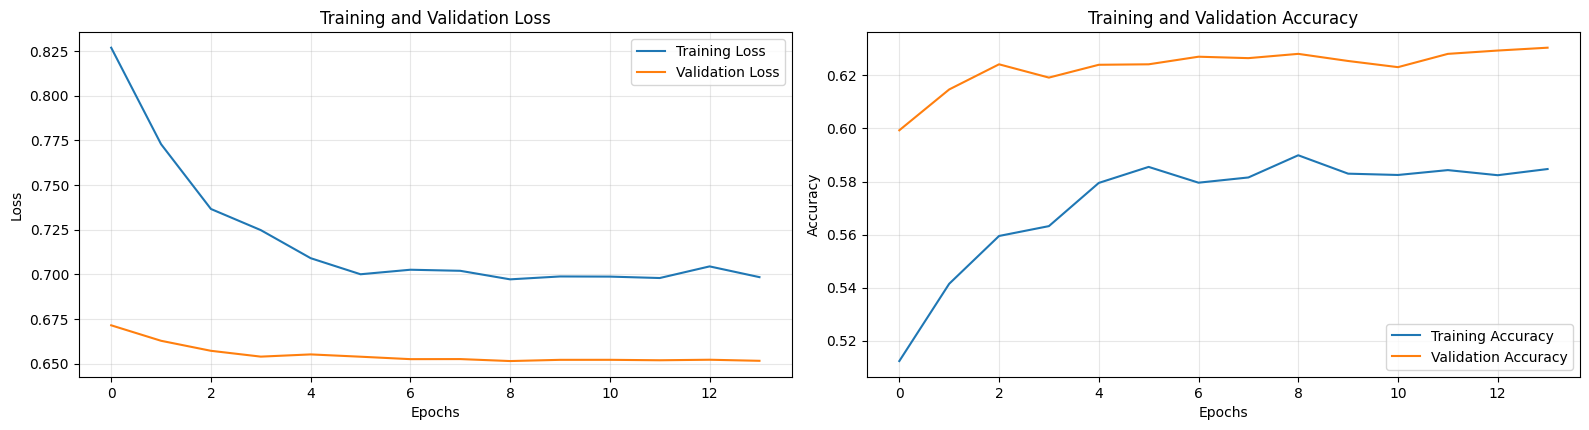


FINAL METRICS SUMMARY
Loss           : Train = 0.6984, Val = 0.6515
Binary_accuracy: Train = 0.5847, Val = 0.6305


In [ ]:
def makemodel(output_bias=None):
    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.BatchNormalization()(image)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

imageOnly = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/image_only_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=imageOnly.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## gabung teks ke indobert yang sama

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._2/output/dense/bias:0', 'bert/encoder/layer_._11/attention/self/key/bias:0', 'bert/encoder/layer_._10/intermediate/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/bias:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/layer_._8/output/LayerNorm/beta:0', 'bert/encoder/layer_._6/attention/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/self/key/bias:0', 'bert/encoder/layer_._10/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/output/dense/bias:0', 'bert/encoder/layer_._7/attention/self/value/bias:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 266s 621ms/step - binary_accuracy: 0.5147 - loss: 0.8950 - precision_5: 0.5147 - recall_5: 0.5140 - val_binary_accuracy: 0.6090 - val_loss: 0.6551 - val_precision_5: 0.6093 - val_recall_5: 0.6077 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 210s 599ms/step - binary_accuracy: 0.5867 - loss: 0.7573 - precision_5: 0.5868 - recall_5: 0.5865 - val_binary_accuracy: 0.6766 - val_loss: 0.6074 - val_precision_5: 0.6768 - val_recall_5: 0.6761 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 206s 590ms/step - binary_accuracy: 0.6178 - loss: 0.7094 - precision_5: 0.6179 - recall_5: 0.6175 - val_binary_accuracy: 0.6897 - val_loss: 0.5898 - val_precision_5: 0.6900 - val_recall_5: 0.6890 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 210s 591ms/step - binary_accuracy: 0.6356 - loss: 0.6739 - precision_5: 0.6356 - recall_5: 0.6354 - val_binary_accuracy: 0.7063 - val_loss: 0.5811 - val_precision_5: 0.

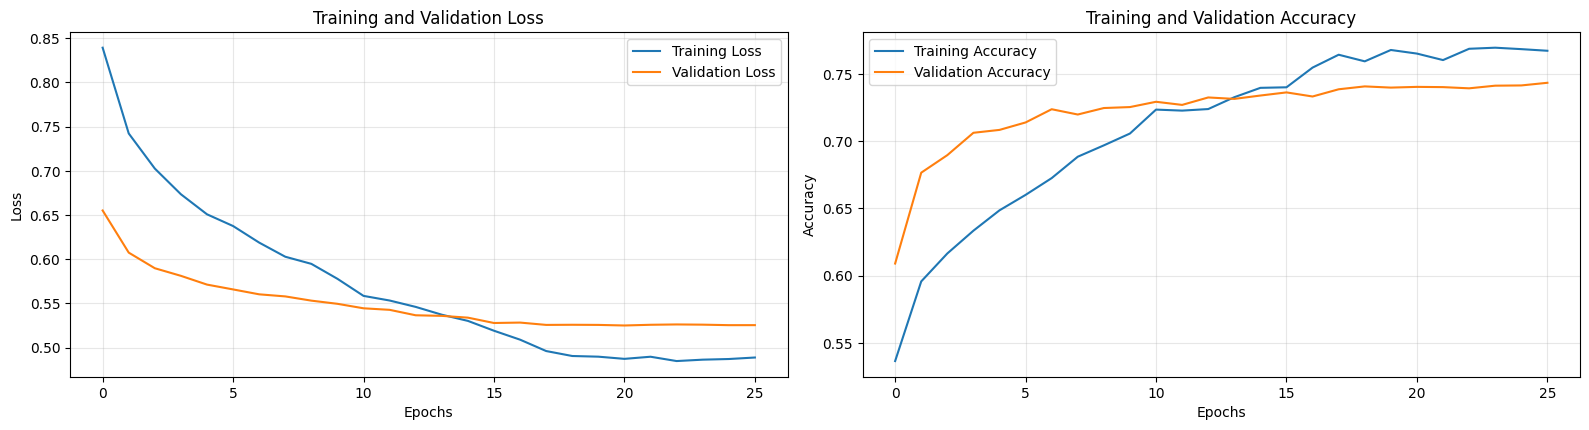


FINAL METRICS SUMMARY
Loss           : Train = 0.4887, Val = 0.5253
Binary_accuracy: Train = 0.7674, Val = 0.7436


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert")

    title = indobert([ids1, att1])
    content = indobert([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

oneBert = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/one_bert_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=oneBert.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )
print(history.history.keys())

final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## without batch normalizing

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._2/output/dense/bias:0', 'bert/encoder/layer_._11/attention/self/key/bias:0', 'bert/encoder/layer_._10/intermediate/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/bias:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/layer_._8/output/LayerNorm/beta:0', 'bert/encoder/layer_._6/attention/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/self/key/bias:0', 'bert/encoder/layer_._10/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/output/dense/bias:0', 'bert/encoder/layer_._7/attention/self/value/bias:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 259s 605ms/step - binary_accuracy: 0.5238 - loss: 1.1626 - precision_6: 0.5238 - recall_6: 0.5235 - val_binary_accuracy: 0.5345 - val_loss: 0.6905 - val_precision_6: 0.5348 - val_recall_6: 0.5311 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 207s 591ms/step - binary_accuracy: 0.5369 - loss: 0.7424 - precision_6: 0.5369 - recall_6: 0.5363 - val_binary_accuracy: 0.5845 - val_loss: 0.6799 - val_precision_6: 0.5850 - val_recall_6: 0.5816 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 206s 590ms/step - binary_accuracy: 0.5438 - loss: 0.7152 - precision_6: 0.5438 - recall_6: 0.5433 - val_binary_accuracy: 0.5821 - val_loss: 0.6854 - val_precision_6: 0.5828 - val_recall_6: 0.5780 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 203s 579ms/step - binary_accuracy: 0.5437 - loss: 0.6976 - precision_6: 0.5438 - recall_6: 0.5430 - val_binary_accuracy: 0.5888 - val_loss: 0.6848 - val_precision_6: 0.

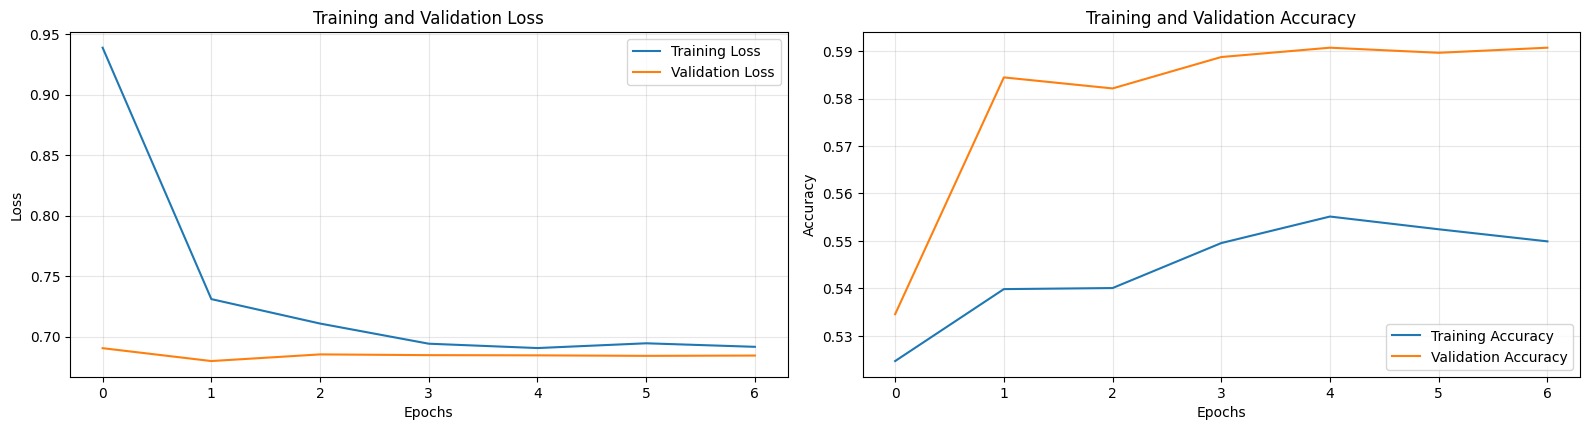


FINAL METRICS SUMMARY
Loss           : Train = 0.6916, Val = 0.6844
Binary_accuracy: Train = 0.5499, Val = 0.5907


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert")

    title = indobert([ids1, att1])
    content = indobert([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

noNorm = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/no_norm_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=noNorm.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )
print(history.history.keys())

final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## Jumlah dense layer

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/encoder/layer_._9/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._8/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._3/attention/self/query/kernel:0', 'bert/encoder/layer_._8/output/dense/bias:0', 'bert/encoder/layer_._2/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/self/query/bias:0', 'bert/encoder/layer_._3/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._1/attention/self/value/bias:0', 'bert/encoder/layer_._0/output/LayerNorm/gamma:0', 'bert/encoder/layer_._5/output/dense/bias:0', 'bert/encoder/layer_._3/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._10/attention/self/key/bias:0', 'bert/encoder/layer_._10/attention/self/value/bias:0', 'bert/encoder/layer_._6/output/LayerNorm/beta:0', 'be

Epoch 1/50


2025-05-27 23:26:33.382154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-05-27 23:26:38.474169: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


350/350 ━━━━━━━━━━━━━━━━━━━━ 254s 591ms/step - binary_accuracy: 0.5087 - loss: 0.7712 - precision: 0.5087 - recall: 0.5087 - val_binary_accuracy: 0.6059 - val_loss: 0.6754 - val_precision: 0.6059 - val_recall: 0.6059 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 199s 568ms/step - binary_accuracy: 0.5933 - loss: 0.6962 - precision: 0.5933 - recall: 0.5933 - val_binary_accuracy: 0.6711 - val_loss: 0.6320 - val_precision: 0.6711 - val_recall: 0.6711 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 199s 567ms/step - binary_accuracy: 0.6308 - loss: 0.6698 - precision: 0.6308 - recall: 0.6308 - val_binary_accuracy: 0.6832 - val_loss: 0.6041 - val_precision: 0.6832 - val_recall: 0.6832 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 199s 569ms/step - binary_accuracy: 0.6640 - loss: 0.6313 - precision: 0.6640 - recall: 0.6640 - val_binary_accuracy: 0.6961 - val_loss: 0.5904 - val_precision: 0.6961 - val_recall: 0.6961 - learning_rate

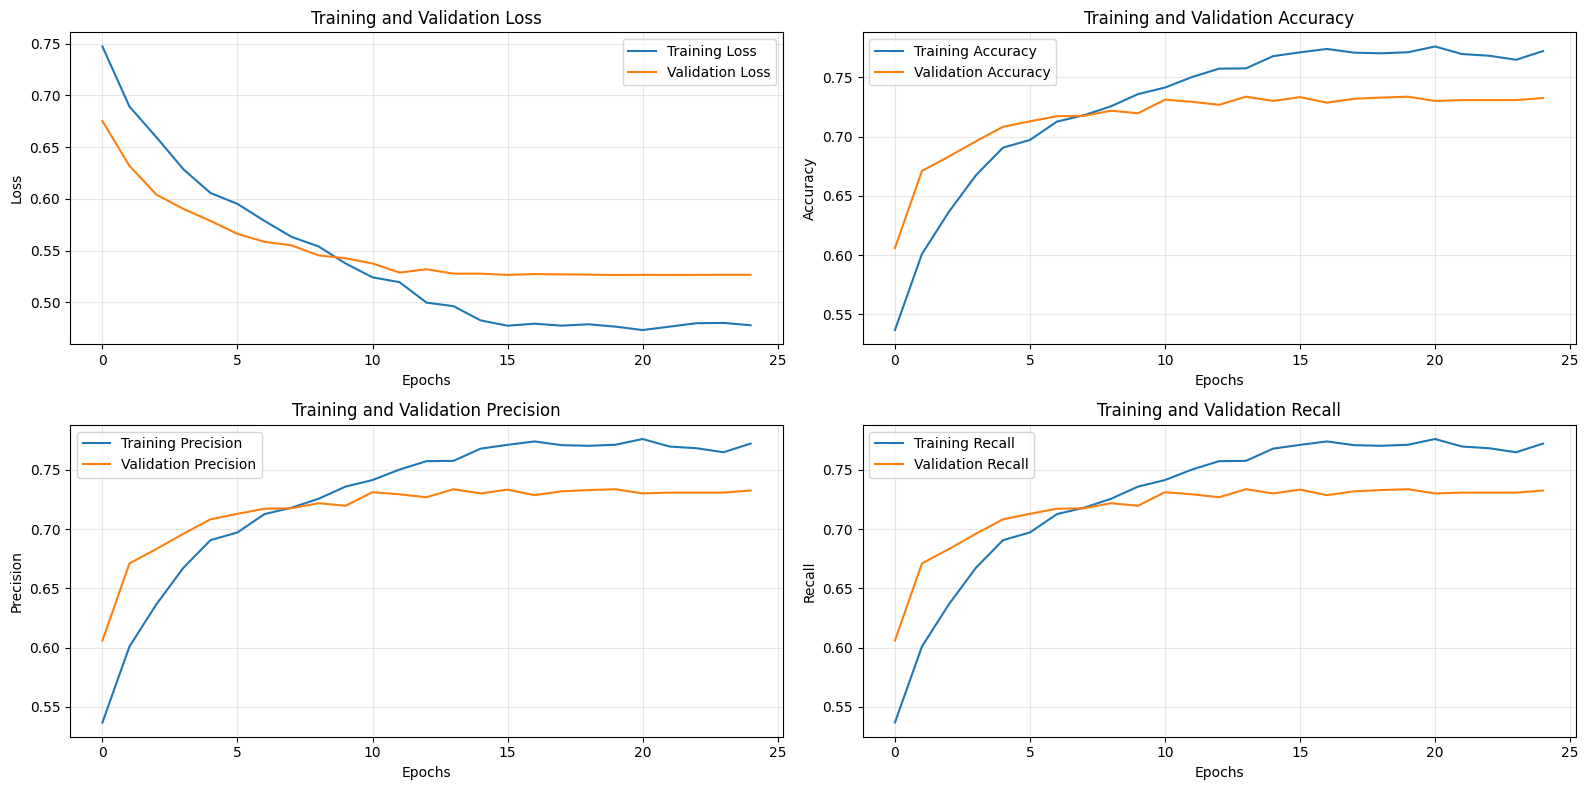


FINAL METRICS SUMMARY
Loss           : Train = 0.4779, Val = 0.5267
Binary_accuracy: Train = 0.7722, Val = 0.7326
Precision      : Train = 0.7722, Val = 0.7326
Recall         : Train = 0.7722, Val = 0.7326


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")
    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    title = indobert1([ids1, att1])
    content = indobert2([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.3)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.3)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

moreDense = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/more_dense_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=moreDense.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )
print(history.history.keys())

final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/encoder/layer_._9/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._8/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._3/attention/self/query/kernel:0', 'bert/encoder/layer_._8/output/dense/bias:0', 'bert/encoder/layer_._2/output/dense/kernel:0', 'bert/encoder/layer_._4/attention/self/query/bias:0', 'bert/encoder/layer_._3/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._1/attention/self/value/bias:0', 'bert/encoder/layer_._0/output/LayerNorm/gamma:0', 'bert/encoder/layer_._5/output/dense/bias:0', 'bert/encoder/layer_._3/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._10/attention/self/key/bias:0', 'bert/encoder/layer_._10/attention/self/value/bias:0', 'bert/encoder/layer_._6/output/LayerNorm/beta:0', 'be

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 263s 610ms/step - binary_accuracy: 0.5702 - loss: 0.7556 - precision_1: 0.5702 - recall_1: 0.5700 - val_binary_accuracy: 0.6158 - val_loss: 0.6522 - val_precision_1: 0.6161 - val_recall_1: 0.6145 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 208s 595ms/step - binary_accuracy: 0.6352 - loss: 0.6701 - precision_1: 0.6353 - recall_1: 0.6348 - val_binary_accuracy: 0.6829 - val_loss: 0.6000 - val_precision_1: 0.6832 - val_recall_1: 0.6822 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 206s 589ms/step - binary_accuracy: 0.6539 - loss: 0.6399 - precision_1: 0.6539 - recall_1: 0.6538 - val_binary_accuracy: 0.6899 - val_loss: 0.5876 - val_precision_1: 0.6901 - val_recall_1: 0.6893 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 206s 588ms/step - binary_accuracy: 0.6773 - loss: 0.6114 - precision_1: 0.6774 - recall_1: 0.6770 - val_binary_accuracy: 0.7110 - val_loss: 0.5759 - val_precision_1: 0.

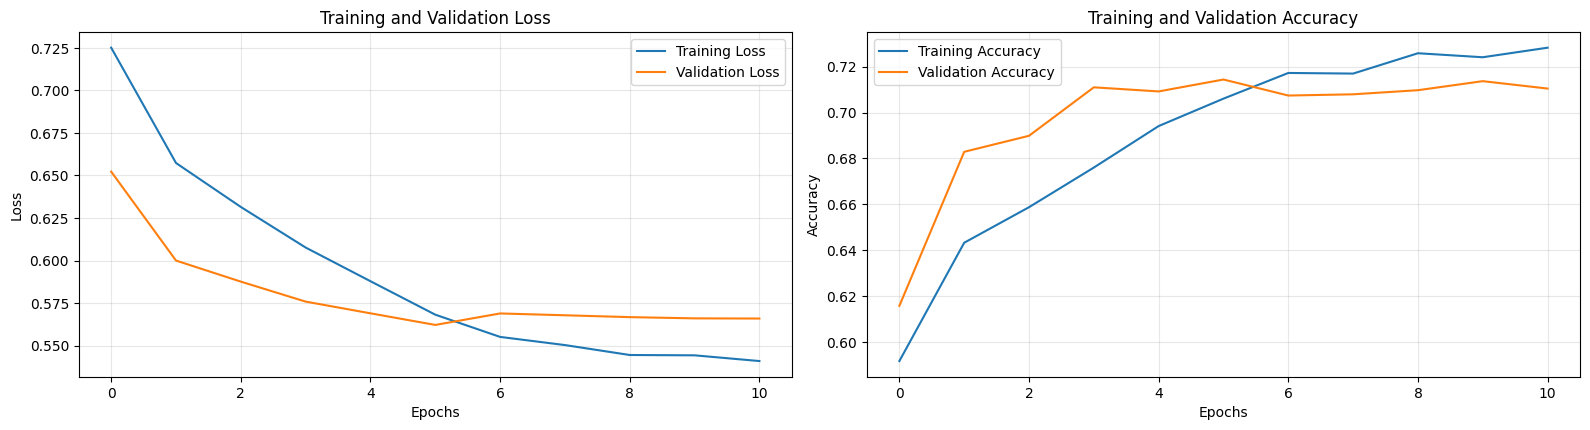


FINAL METRICS SUMMARY
Loss           : Train = 0.5409, Val = 0.5659
Binary_accuracy: Train = 0.7283, Val = 0.7105


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")
    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    title = indobert1([ids1, att1])
    content = indobert2([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.3)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.3)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(2, activation='softmax')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

lessDense = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/less_dense_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=lessDense.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )
print(history.history.keys())

final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()